In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com'
                 '/jinh-tech/Sberbank-Russian-Housing-Market/master/data/train.csv')

df.price_doc = df.price_doc.apply(np.log1p)
df = df.rename(columns={'price_doc': 'log_price_doc'})

In [3]:
df.shape

(30471, 292)

In [4]:
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

Будем оценивать качество модели по MSLE

In [5]:
df.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

In [6]:
df.isna().any().sum()

51

EDA и заполнение пропусков

Заполняем пропуски в каждой колонке ее средним значением

In [7]:
numerical_columns = df.loc[: ,df.dtypes != object].columns

In [8]:
for col in numerical_columns:
    df[col] = df[col].fillna(df[col].mean())

In [9]:
df.isna().any().sum()

0

Удаляем признаки с высокой корреляцией (>= 0.9 по модулю) 

In [10]:
corr_matrix = df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]

df.drop(to_drop, axis=1, inplace=True)

Проверяем, действительно ли мы почистили матрицу

In [11]:
corr_matrix = df.corr().abs()
for i in range(corr_matrix.shape[1]):
    for j in range(corr_matrix.shape[0]):
        if corr_matrix.values[i][j] > 0.9 and i != j:
            print('High correlation')

In [12]:
df.shape

(30471, 145)

Найдем квазиконстантные признаки с малыми показателями дисперсии

In [13]:
numerical_columns = df.loc[: ,df.dtypes != object].columns

In [14]:
len(numerical_columns)

129

In [15]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selector.fit(df[numerical_columns])

const_columns = [x for x in numerical_columns if x not in selector.get_feature_names_out()]
df[const_columns].head(10)

,green_zone_part,indust_part,green_zone_km,cafe_count_500_price_high,mosque_count_500,mosque_count_1000,mosque_count_1500,mosque_count_2000
0,0.189727,0.000070,0.600973,0,0,0,0,0
1,0.372602,0.049637,0.065321,0,0,0,0,0
2,0.112560,0.118537,0.453172,0,0,0,0,0
3,0.194703,0.069753,0.106125,0,0,0,0,0
4,0.015234,0.037316,0.236214,0,0,0,0,0
5,0.007670,0.486246,1.497903,0,0,0,0,0
6,0.523439,0.042307,0.632445,0,0,0,0,0
7,0.189727,0.000070,0.165124,0,0,0,0,0
8,0.038456,0.122090,0.148957,0,0,0,0,0
9,0.070662,0.035145,0.191191,0,0,0,0,0


In [16]:
categorical_columns = df.loc[:, df.dtypes == object].columns
categorical_columns

Index(['timestamp', 'product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology'],
      dtype='object')

In [17]:
df[categorical_columns].describe(include='object')

,timestamp,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
count,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471,30471
unique,1161,2,146,2,2,2,2,2,2,2,2,2,2,2,2,5
top,2014-12-16,Investment,Poselenie Sosenskoe,no,no,no,no,no,no,no,no,no,no,no,no,poor
freq,160,19448,1776,28543,28817,28155,30175,19600,29335,27649,29608,27427,28134,29690,29578,8018


In [18]:
for col in categorical_columns:
    if col != 'timestamp':
        if df[col].nunique() < 5:
            one_hot_df = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat((df.drop(col, axis=1), one_hot_df), axis=1)
        else:
            df[col] = df[col].map(df.groupby(col).log_price_doc.mean())

In [19]:
s = df.groupby('sub_area').log_price_doc

In [20]:
categorical_columns

Index(['timestamp', 'product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology'],
      dtype='object')

In [21]:
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_quota,preschool_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_mix,build_count_before_1920,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,kindergarten_km,school_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,ID_railroad_station_walk,ID_railroad_station_avto,public_transport_station_km,water_km,mkad_km,ttk_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,hospice_morgue_km,detention_facility_km,university_km,workplaces_km,office_km,additional_education_km,church_synagogue_km,mosque_km,theater_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,mosque_count_1000,sport_count_1000,market_count_1000,green_part_1500,trc_count_1500,trc_sqm_1500,cafe_sum_1500_min_price_avg,mosque_count_1500,sport_count_1500,market_count_1500,trc_sqm_2000,cafe_sum_2000_min_price_avg,mosque_count_2000,market_count_2000,prom_part_3000,trc_sqm_3000,cafe_sum_3000_min_price_avg,mosque_count_3000,market_count_3000,green_part_5000,prom_part_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,log_price_doc,product_type_OwnerOccupier,culture_objects_top_25_yes,thermal_power_plant_raion_yes,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes
0,1,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.594247,6.407578e+06,155572,0.189727,0.000070,5001.0,5,0,240.000000,1,0,7,3,0,16,1,86206,211.0,25.0,0.0,0.0,0.0,2.0,184.0,0.0,0.0,0.0,0.0,206.0,5.0,1,2.590241,0.145700,0.177975,0.600973,1.080934,23.683460,1.804127,3.633334,5.419893,1.0,1,0.274985,0.992631,1.422391,10.918587,1.422391,1,3.830951,5,1.305159,101,24.292406,1,18.152338,5.718519,4.308127,10.814172,1.676258,0.485841,3.065047,1.107594,2.392353,4.248036,6.715026,0.884350,0.637189,0.947962,0.628187,3.932040,14.053047,0.516838,15.628160,0.00,0.00,0,0,0,0,0,741.319572,0,0,0,0,0,1,0,7.36,0.00,30500,3,55600,527.78,0,0,6,1,14.27,9,171420,566.67,0,7,1,1244891,614.29,0,1,13.55,1419204,639.68,0,1,13.09,13.31,4036616,708.57,1,4,15.581952,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.864842,9.589337e+06,115352,0.372602,0.049637,3119.0,5,0,229.000000,1,0,6,1,1,3,0,76284,245.0,83.0,1.0,0.0,67.0,4.0,90.0,0.0,0.0,1.0,143.0,84.0,15.0,2,0.936700,0.147754,0.273345,0.065321,0.966479,1.317476,4.655004,8.648587,3.411993,2.0,2,0.065263,0.698081,9.503405,3.103996,2.887377,2,3.103996,4,0.694536,32,5.706113,2,9.034642,3.489954,0.725560,6.910568,3.424716,0.668364,2.000154,8.972823,2.543747,12.649879,1.852560,0.686252,0.688796,1.072315,0.471447,4.841544,6.829889,0.230287,15.719018,25.14,0.00,0,0,0,0,5,860.000000,1,0,0,0,0,0,0,26.66,0.07,86600,5,94065,615.38,0,0,2,0,21.53,7,12

In [22]:
df.shape

(30471, 145)

In [23]:
df.timestamp = pd.to_datetime(df.timestamp)

df['year'] = df.timestamp.dt.year
df['month'] = df.timestamp.dt.month

In [24]:
df.shape[1]

147

In [25]:
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_quota,preschool_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_mix,build_count_before_1920,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,kindergarten_km,school_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,ID_railroad_station_walk,ID_railroad_station_avto,public_transport_station_km,water_km,mkad_km,ttk_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,hospice_morgue_km,detention_facility_km,university_km,workplaces_km,office_km,additional_education_km,church_synagogue_km,mosque_km,theater_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,mosque_count_1000,sport_count_1000,market_count_1000,green_part_1500,trc_count_1500,trc_sqm_1500,cafe_sum_1500_min_price_avg,mosque_count_1500,sport_count_1500,market_count_1500,trc_sqm_2000,cafe_sum_2000_min_price_avg,mosque_count_2000,market_count_2000,prom_part_3000,trc_sqm_3000,cafe_sum_3000_min_price_avg,mosque_count_3000,market_count_3000,green_part_5000,prom_part_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,log_price_doc,product_type_OwnerOccupier,culture_objects_top_25_yes,thermal_power_plant_raion_yes,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,year,month
0,1,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.594247,6.407578e+06,155572,0.189727,0.000070,5001.0,5,0,240.000000,1,0,7,3,0,16,1,86206,211.0,25.0,0.0,0.0,0.0,2.0,184.0,0.0,0.0,0.0,0.0,206.0,5.0,1,2.590241,0.145700,0.177975,0.600973,1.080934,23.683460,1.804127,3.633334,5.419893,1.0,1,0.274985,0.992631,1.422391,10.918587,1.422391,1,3.830951,5,1.305159,101,24.292406,1,18.152338,5.718519,4.308127,10.814172,1.676258,0.485841,3.065047,1.107594,2.392353,4.248036,6.715026,0.884350,0.637189,0.947962,0.628187,3.932040,14.053047,0.516838,15.628160,0.00,0.00,0,0,0,0,0,741.319572,0,0,0,0,0,1,0,7.36,0.00,30500,3,55600,527.78,0,0,6,1,14.27,9,171420,566.67,0,7,1,1244891,614.29,0,1,13.55,1419204,639.68,0,1,13.09,13.31,4036616,708.57,1,4,15.581952,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,8
1,2,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.864842,9.589337e+06,115352,0.372602,0.049637,3119.0,5,0,229.000000,1,0,6,1,1,3,0,76284,245.0,83.0,1.0,0.0,67.0,4.0,90.0,0.0,0.0,1.0,143.0,84.0,15.0,2,0.936700,0.147754,0.273345,0.065321,0.966479,1.317476,4.655004,8.648587,3.411993,2.0,2,0.065263,0.698081,9.503405,3.103996,2.887377,2,3.103996,4,0.694536,32,5.706113,2,9.034642,3.489954,0.725560,6.910568,3.424716,0.668364,2.000154,8.972823,2.543747,12.649879,1.852560,0.686252,0.688796,1.072315,0.471447,4.841544,6.829889,0.230287,15.719018,25.14,0.00,0,0,0,0,5,860.000000,1,0,0,0,0,0,0,26.66,0.07,86600,5,94065,615.38,

In [26]:
df = df.sort_values(by='timestamp')
df = df.drop('timestamp', axis=1)

Text(0.5, 1.0, 'Распределение таргета по годам')

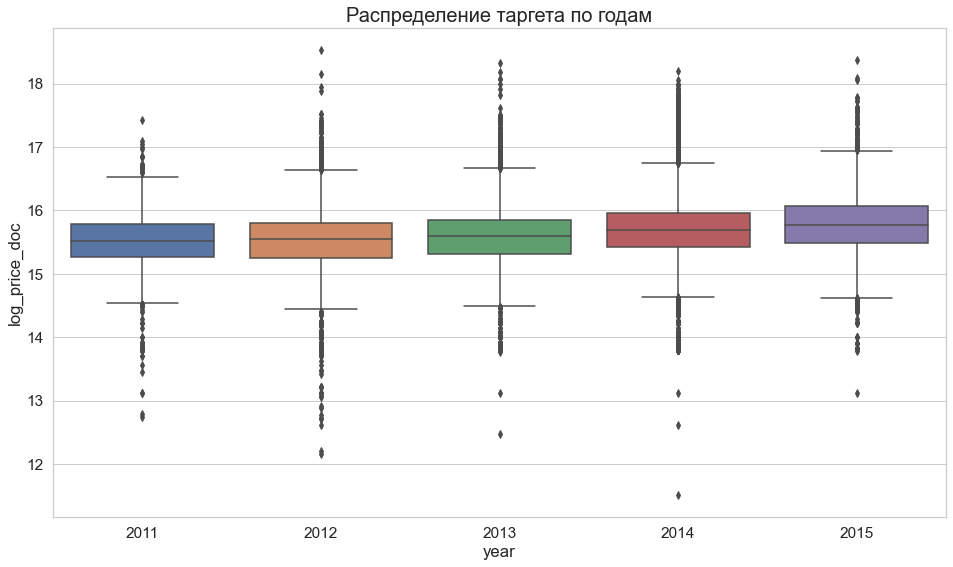

In [27]:
fig = plt.figure(figsize=(16, 9))
sns.set(style='whitegrid', font_scale=1.4)

sns.boxplot(x=df.year, y=df.log_price_doc)

plt.title('Распределение таргета по годам', fontsize=20)

In [28]:
one_hot = pd.get_dummies(df['year'], prefix='year', drop_first=True)

df = pd.concat((df.drop('year', axis=1), one_hot), axis=1)

In [29]:
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_quota,preschool_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_mix,build_count_before_1920,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,kindergarten_km,school_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,ID_railroad_station_walk,ID_railroad_station_avto,public_transport_station_km,water_km,mkad_km,ttk_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,hospice_morgue_km,detention_facility_km,university_km,workplaces_km,office_km,additional_education_km,church_synagogue_km,mosque_km,theater_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,mosque_count_1000,sport_count_1000,market_count_1000,green_part_1500,trc_count_1500,trc_sqm_1500,cafe_sum_1500_min_price_avg,mosque_count_1500,sport_count_1500,market_count_1500,trc_sqm_2000,cafe_sum_2000_min_price_avg,mosque_count_2000,market_count_2000,prom_part_3000,trc_sqm_3000,cafe_sum_3000_min_price_avg,mosque_count_3000,market_count_3000,green_part_5000,prom_part_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,log_price_doc,product_type_OwnerOccupier,culture_objects_top_25_yes,thermal_power_plant_raion_yes,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,month,year_2012,year_2013,year_2014,year_2015
0,1,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.594247,6.407578e+06,155572,0.189727,0.000070,5001.0,5,0,240.000000,1,0,7,3,0,16,1,86206,211.0,25.0,0.0,0.0,0.0,2.0,184.0,0.0,0.0,0.0,0.0,206.0,5.0,1,2.590241,0.145700,0.177975,0.600973,1.080934,23.683460,1.804127,3.633334,5.419893,1.0,1,0.274985,0.992631,1.422391,10.918587,1.422391,1,3.830951,5,1.305159,101,24.292406,1,18.152338,5.718519,4.308127,10.814172,1.676258,0.485841,3.065047,1.107594,2.392353,4.248036,6.715026,0.884350,0.637189,0.947962,0.628187,3.932040,14.053047,0.516838,15.628160,0.00,0.00,0,0,0,0,0,741.319572,0,0,0,0,0,1,0,7.36,0.00,30500,3,55600,527.78,0,0,6,1,14.27,9,171420,566.67,0,7,1,1244891,614.29,0,1,13.55,1419204,639.68,0,1,13.09,13.31,4036616,708.57,1,4,15.581952,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0
1,2,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.864842,9.589337e+06,115352,0.372602,0.049637,3119.0,5,0,229.000000,1,0,6,1,1,3,0,76284,245.0,83.0,1.0,0.0,67.0,4.0,90.0,0.0,0.0,1.0,143.0,84.0,15.0,2,0.936700,0.147754,0.273345,0.065321,0.966479,1.317476,4.655004,8.648587,3.411993,2.0,2,0.065263,0.698081,9.503405,3.103996,2.887377,2,3.103996,4,0.694536,32,5.706113,2,9.034642,3.489954,0.725560,6.910568,3.424716,0.668364,2.000154,8.972823,2.543747,12.649879,1.852560,0.686252,0.688796,1.072315,0.471447,4.841544,6.829889,0.230287,15.719018,25.14,0.00,0,0,0,0,5,860.000000,1,0,0,0,

Text(0.5, 1.0, 'Распределение таргета по месяцам')

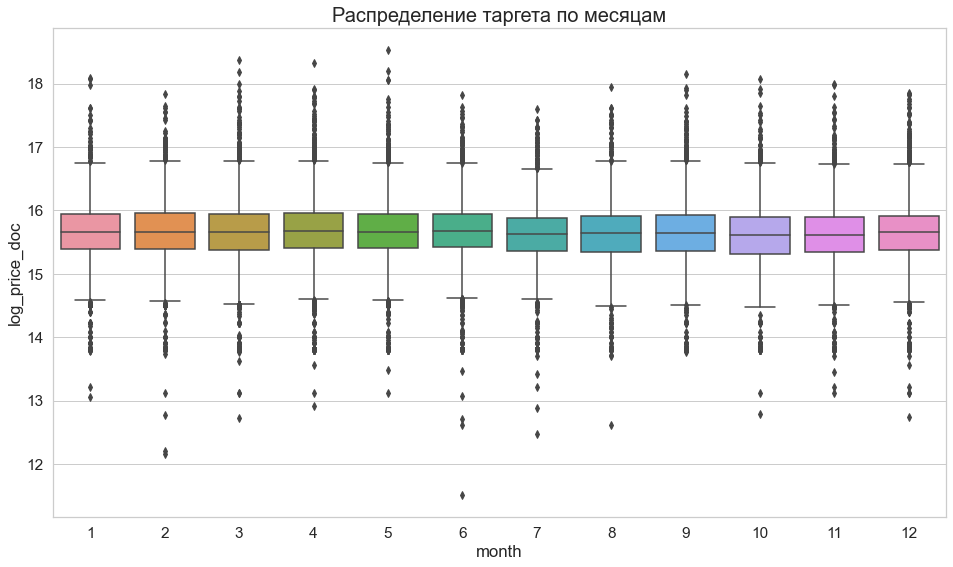

In [30]:
fig = plt.figure(figsize=(16, 9))

sns.boxplot(x=df.month, y=df.log_price_doc)

plt.title('Распределение таргета по месяцам', fontsize=20)

In [31]:
one_hot = pd.get_dummies(df.month, prefix='month', drop_first=True)

df = pd.concat((df.drop('month', axis=1), one_hot), axis=1)

In [32]:
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_quota,preschool_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_mix,build_count_before_1920,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,kindergarten_km,school_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,ID_railroad_station_walk,ID_railroad_station_avto,public_transport_station_km,water_km,mkad_km,ttk_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,hospice_morgue_km,detention_facility_km,university_km,workplaces_km,office_km,additional_education_km,church_synagogue_km,mosque_km,theater_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_sum_1000_min_price_avg,cafe_count_1000_price_high,mosque_count_1000,sport_count_1000,market_count_1000,green_part_1500,trc_count_1500,trc_sqm_1500,cafe_sum_1500_min_price_avg,mosque_count_1500,sport_count_1500,market_count_1500,trc_sqm_2000,cafe_sum_2000_min_price_avg,mosque_count_2000,market_count_2000,prom_part_3000,trc_sqm_3000,cafe_sum_3000_min_price_avg,mosque_count_3000,market_count_3000,green_part_5000,prom_part_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,log_price_doc,product_type_OwnerOccupier,culture_objects_top_25_yes,thermal_power_plant_raion_yes,incineration_raion_yes,oil_chemistry_raion_yes,radiation_raion_yes,railroad_terminal_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,year_2012,year_2013,year_2014,year_2015,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,2011-08-20,43,27.0,4.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.594247,6.407578e+06,155572,0.189727,0.000070,5001.0,5,0,240.000000,1,0,7,3,0,16,1,86206,211.0,25.0,0.0,0.0,0.0,2.0,184.0,0.0,0.0,0.0,0.0,206.0,5.0,1,2.590241,0.145700,0.177975,0.600973,1.080934,23.683460,1.804127,3.633334,5.419893,1.0,1,0.274985,0.992631,1.422391,10.918587,1.422391,1,3.830951,5,1.305159,101,24.292406,1,18.152338,5.718519,4.308127,10.814172,1.676258,0.485841,3.065047,1.107594,2.392353,4.248036,6.715026,0.884350,0.637189,0.947962,0.628187,3.932040,14.053047,0.516838,15.628160,0.00,0.00,0,0,0,0,0,741.319572,0,0,0,0,0,1,0,7.36,0.00,30500,3,55600,527.78,0,0,6,1,14.27,9,171420,566.67,0,7,1,1244891,614.29,0,1,13.55,1419204,639.68,0,1,13.09,13.31,4036616,708.57,1,4,15.581952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,2011-08-23,34,19.0,3.0,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,15.864842,9.589337e+06,115352,0.372602,0.049637,3119.0,5,0,229.000000,1,0,6,1,1,3,0,76284,245.0,83.0,1.0,0.0,67.0,4.0,90.0,0.0,0.0,1.0,143.0,84.0,15.0,2,0.936700,0.147754,0.273345,0.065321,0.966479,1.317476,4.655004,8.648587,3.411993,2.0,2,0.065263,0.698081,9.503405,3.103996,2.887377,2,3.103996,4,0.694536,32,5.706113,2,9.034642,3.489954,0.725560,6.910568,3.424716,0.668364,2.000154,8.972823,2.543747,12.649879,1.852560,0.686252

<AxesSubplot:xlabel='floor', ylabel='log_price_doc'>

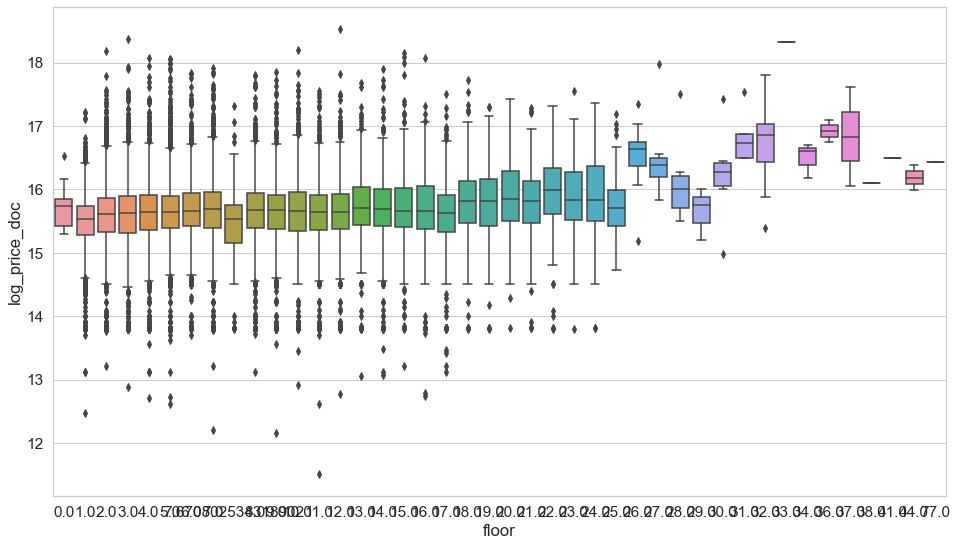

In [34]:
fig = plt.figure(figsize=(16, 9))

sns.boxplot(x=df.floor, y=df.log_price_doc)

In [36]:
X = df.drop('log_price_doc',axis=1)
y = df.log_price_doc

Не можем использовать кросс-валидацию, так как хотим делать прогнозы на будущее
Тогда тренироваться надо на более ранних, а тестировать - на поздних

In [38]:
from sklearn.model_selection import TimeSeriesSplit

splitter = TimeSeriesSplit(n_splits=4)

In [42]:
# from sklearn.linear_model import LinearRegression

# test_losses = []
# train_losses = []

# for train_index, test_index in splitter.split(X):
#     X_train, X_test = X.values[train_index], X.values[test_index]
#     y_train, y_test = y.values[train_index], y.values[test_index]
    
#     model = LinearRegression()
#     model.fit(X_train, y_train)
    
#     test_losses.append(np.mean((model.predict(X_test) - y_test) ** 2))
#     train_losses.append(np.mean((model.predict(X_train) - y_train) ** 2))
# print('Mean test MSLE:', np.mean(test_losses))
# print('Mean train MSLE:', np.mean(train_losses))

Mean test MSLE: 0.3967458003141079
Mean train MSLE: 0.2816660419857496


In [46]:
from sklearn.model_selection import cross_validate

model = LinearRegression()

cv_score = cross_validate(model, X, y
                          , scoring='neg_mean_squared_error'
                          , cv=splitter, return_train_score=True)

In [48]:
print('LR test MSLE:', -np.mean(cv_score['test_score']))
print('LR train MSLE:', -npa.mean(cv_score['train_score']))

Mean test MSLE: 0.39674587615118195
Mean train MSLE: 0.2816660419857496


Lasso mean test MSLE: 0.34622696988522617
Lasso mean train MSLE: 0.3262874511838941


Масштабирование на тренировочных данных

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=100000))
])

# pipeline.fit(X, y)

pipe_lasso_score = cross_validate(pipeline, X, y
                          , scoring='neg_mean_squared_error'
                          , cv=splitter, return_train_score=True)

In [61]:
print('Pipe test MSLE:', -np.mean(pipe_lasso_score['test_score']))
print('Pipe train MSLE:', -np.mean(pipe_lasso_score['train_score']))

Pipe test MSLE: 0.35455832037692214
Pipe train MSLE: 0.3821426743642796


In [71]:
from sklearn.model_selection import GridSearchCV

alphas = np.linspace(0.01, 1, num=30)

param_grid = {
    'lasso__alpha': alphas
}

search = GridSearchCV(pipeline, param_grid
                      , cv=splitter, scoring='neg_mean_squared_error')
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso(max_iter=100000))]),
             param_grid={'lasso__alpha': array([0.01      , 0.04413793, 0.07827586, 0.11241379, 0.14655172,
       0.18068966, 0.21482759, 0.24896552, 0.28310345, 0.31724138,
       0.35137931, 0.38551724, 0.41965517, 0.4537931 , 0.48793103,
       0.52206897, 0.5562069 , 0.59034483, 0.62448276, 0.65862069,
       0.69275862, 0.72689655, 0.76103448, 0.79517241, 0.82931034,
       0.86344828, 0.89758621, 0.93172414, 0.96586207, 1.        ])},
             scoring='neg_mean_squared_error')

In [77]:
search.best_params_

{'lasso__alpha': 0.11241379310344828}

In [76]:
print(f'Best score: {-search.best_score_}')

Best score: 0.302955272798318


In [83]:
upper_quantile = df.log_price_doc.quantile(0.975).round(2)
lower_quantile = df.log_price_doc.quantile(0.025).round(2)

In [85]:
no_outliers_df = df[(df.log_price_doc > lower_quantile) 
                    & (df.log_price_doc < upper_quantile)].copy()

In [86]:
X_new = no_outliers_df.drop('log_price_doc',axis=1)
y_new = no_outliers_df.log_price_doc

In [88]:
new_splitter = TimeSeriesSplit(n_splits=4)

param_grid = {
    'lasso__alpha': alphas
}

search = GridSearchCV(pipeline, param_grid
                      , cv=new_splitter, scoring='neg_mean_squared_error')
search.fit(X_new, y_new)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso(max_iter=100000))]),
             param_grid={'lasso__alpha': array([0.01      , 0.04413793, 0.07827586, 0.11241379, 0.14655172,
       0.18068966, 0.21482759, 0.24896552, 0.28310345, 0.31724138,
       0.35137931, 0.38551724, 0.41965517, 0.4537931 , 0.48793103,
       0.52206897, 0.5562069 , 0.59034483, 0.62448276, 0.65862069,
       0.69275862, 0.72689655, 0.76103448, 0.79517241, 0.82931034,
       0.86344828, 0.89758621, 0.93172414, 0.96586207, 1.        ])},
             scoring='neg_mean_squared_error')

In [90]:
search.best_score_

-0.1673792328729748

In [91]:
search.best_params_

{'lasso__alpha': 0.04413793103448276}

In [99]:
pipeline.set_params(lasso__alpha=search.best_params_['lasso__alpha'])

cross_validate(pipeline, X_new, y_new
               , scoring='neg_mean_squared_error', cv=new_splitter
               , return_train_score=True)


{'fit_time': array([0.03643584, 0.09394717, 0.094275  , 0.08148718]),
 'score_time': array([0.00527501, 0.00405669, 0.00369096, 0.00371504]),
 'test_score': array([-0.14699373, -0.24093574, -0.14609093, -0.13549654]),
 'train_score': array([-0.16744554, -0.15384409, -0.15554568, -0.15144528])}

#### Check score on new data

In [111]:
test_df = pd.read_csv('test.csv')

In [112]:
test_df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [109]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.04413793103448276, max_iter=100000))])

Сегментация данных

Text(0.5, 1.0, 'Первичный и вторичный рынки жилья')

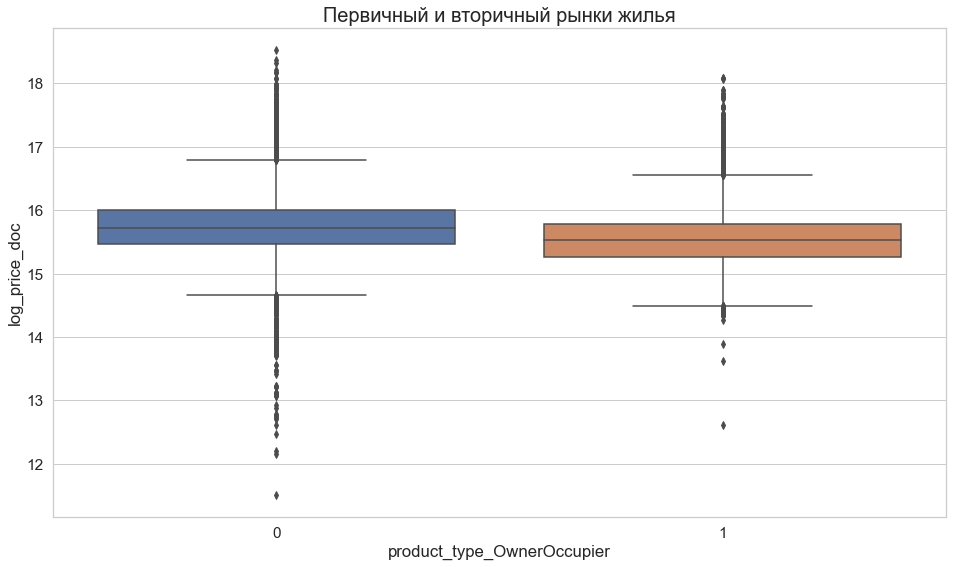

In [103]:
fig = plt.figure(figsize=(16, 9))

sns.boxplot(x=df.product_type_OwnerOccupier, y=df.log_price_doc)

plt.title('Первичный и вторичный рынки жилья', fontsize=20)

In [107]:
Owner_occupier = df[df.product_type_OwnerOccupier == 1].copy()
Investment = df[df.product_type_OwnerOccupier == 0].copy()

X_occ, y_occ = Owner_occupier.drop('log_price_doc', axis=1), Owner_occupier.log_price_doc
X_inv, y_inv = Investment.drop('log_price_doc', axis=1), Investment.log_price_doc

### TODO